In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import kornia

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

h_image_size = 16
h_max_allowable_filters = 128
h_batch_size = 512
train_dir = 'Train/'
test_dir = 'Test/'

In [2]:
class image_dataset(torch.utils.data.Dataset):

    def __init__(self, batch_size, directory, training=True):
        super().__init__()
        self.image_dir = directory
        self.batch_size = batch_size
        self.directory = directory
        self.training = training
    
    def __len__(self):
        return len(os.listdir(self.directory))/self.batch_size

    def __getitem__(self, index):
        all_file_paths = [self.directory + file_name for file_name in os.listdir(self.directory)]
        file_batch = all_file_paths[index * self.batch_size:(index+1) * self.batch_size]

        #batch = torch.empty((0, 3, h_image_size, h_image_size))
        batch_l_channel = torch.empty((0, 1, h_image_size, h_image_size))
        batch_ab_channels = torch.empty((0, 2, h_image_size, h_image_size))
        for file_path in file_batch:

            image_l_channel, image_ab_channels = self.prepare_image(file_path)
            #batch = torch.cat((batch, image))
            batch_l_channel = torch.cat((batch_l_channel, torch.unsqueeze(image_l_channel,0)))
            batch_ab_channels = torch.cat((batch_ab_channels, image_ab_channels))
            
        #l_channels = torch.unsqueeze(batch[:,0,:,:],1)
        #ab_channels = batch[:,1:,:,:]
        #return l_channels, ab_channels

        return batch_l_channel, batch_ab_channels

    def prepare_image(self, filepath):

        image = torchvision.io.read_image(filepath)
        
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        if self.training:
            image = torchvision.transforms.RandomHorizontalFlip()(image)
            image = torchvision.transforms.RandomVerticalFlip()(image)
        image = image = torch.unsqueeze(image,0)
        image = kornia.color.rgb_to_lab(image)
        image = torch.div(torch.add(image, -128),128)

        l_channel = image[:,0,:,:]
        ab_channels = image[:,1:,:,:]
        
        return l_channel, ab_channels

    def load_image_number(self, number):
        all_file_paths = [self.directory + file_name for file_name in os.listdir(self.directory)]
        l_channel, ab_channels = self.prepare_image(all_file_paths[number])
        
        return torch.unsqueeze(l_channel,0), torch.unsqueeze(ab_channels,0)

In [3]:
class Downsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 5, stride = 2 ,padding=2).to('cuda')
        self.res = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 1, stride = 2).to('cuda')
        
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')
        #self.pool = nn.AvgPool2d(2).to('cuda')

    def forward(self, x):
        #print(f'downbl {x.shape}')
        block = self.conv(x)
        #block = self.pool(block)
        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        res = self.res(x)
        block = torch.add(block, res)
        
        return block.to('cuda')

In [4]:
class Upsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 4, stride = 2,
                                      padding=1).to('cuda')
        self.res = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 1, stride = 2,
                                     output_padding=1).to('cuda')
        
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')

    def forward(self, x, skip):

        block = self.conv(x)

        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        res = self.res(x)
        block = torch.add(block, res)
        block = torch.cat((block, skip),1)
        
        return block.to('cuda')

In [5]:
class Generator(nn.Module):

    def __init__(self, image_size, max_filters):
        super().__init__()

        self.n_layers = int(np.floor(np.log2(image_size)))
        self.max_filters = max_filters
        
        self.input = nn.Conv2d(in_channels = 1,out_channels = 16, kernel_size = 5,
                               padding= 2).to('cuda')
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 32, out_channels=2, kernel_size=1, stride=1),
            nn.Tanh()).to('cuda')

        self.apply(self.__init_weights)

        # ==== Create Downsampling Stack ====
        
        self.downstack = []
        for layer in range(self.n_layers):
            if 2 ** (4+layer) < self.max_filters:
                self.downstack.append(Downsampling(in_filters=2 ** (4+layer),
                                                   out_filters=2 ** (5+layer)))
            else:
                self.downstack.append(Downsampling(in_filters=self.max_filters,
                                                   out_filters=self.max_filters))
                
        self.downstack = nn.ModuleList(self.downstack)   

        # ==== Initial Layer for Upsampling Stack ====
        
        if 2 ** (5+self.n_layers) > self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters, out_filters = self.max_filters)]
        else: 
            self.upstack_init = [Upsampling(in_filters = 2 ** (4+self.n_layers),
                                            out_filters = 2 ** (3+self.n_layers))]

        # ==== Create Remaining Upsampling Stack ====
        
        self.upstack = []
        for layer in range(self.n_layers-1):
            if 2**(self.n_layers - layer + 3) > self.max_filters:
                self.upstack.append(Upsampling(in_filters = 2 * self.max_filters,
                                                out_filters = self.max_filters))
            else:
                self.upstack.append(Upsampling(in_filters = 2**(self.n_layers - layer + 4),
                                                out_filters = 2**(self.n_layers - layer + 2)))
                
        self.upstack = nn.ModuleList(self.upstack_init + self.upstack)


    def __init_weights(self, module):

        if isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    
    def forward(self, x):
        
        skips = []
        conv = self.input(x)
        skips.append(conv)
        
        for x in self.downstack:
            skipconv = x(conv)
            skips.append(skipconv)
            conv = skips[-1]
            #print(conv.shape)
            
        for idx, layer in enumerate(self.upstack):
            conv = layer(conv, skips[-(idx+2)])
            #print(conv.shape)
        
        out = self.output(conv)
        # print(out.size())
        #print(out.shape)
        return out

    def colorize(self, x):
        
        predictions = self.forward(x)
        predictions = torch.cat((x, predictions),1)
        predictions = torch.add(predictions.mul(128),127)
        predictions = kornia.color.lab_to_rgb(torch.squeeze(predictions),0)
        predictions = torch.floor(predictions.movedim(0,-1)).to(torch.long)
        
        return predictions

In [6]:
gen = Generator(h_image_size, h_max_allowable_filters).to('cuda')
optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001)
train_dataset = image_dataset(h_batch_size, train_dir, training=True)
test_dataset = image_dataset(16, test_dir, training=False)

epochs = 5 
saves = 5
saved_epochs = []
losses = []

In [7]:
#with torch.autograd.profiler.profile() as prof:

gen.train();
for epoch in tqdm(range(epochs)):
    for batch_idx in range(len(os.listdir(train_dir))//h_batch_size):

        a, b = next(iter(train_dataset))
        a, b = a.to('cuda'), b.to('cuda')
        
        model_out = gen.forward(a)
        loss = F.mse_loss(model_out,b)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
    if not (epoch % epochs//saves):
        gen.eval()

        x, y = test_dataset.load_image_number(42)
        x, y = x.to('cuda'), y.to('cuda')
        predictions = gen.colorize(x)
        saved_epochs.append(predictions.to('cpu').detach().numpy())
        
        gen.train()

gen.eval();      
#print(prof.key_averages().table(sort_by="self_cpu_time_total"))
#torch.save(gen, 'gen.pth')

100%|█████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.92s/it]


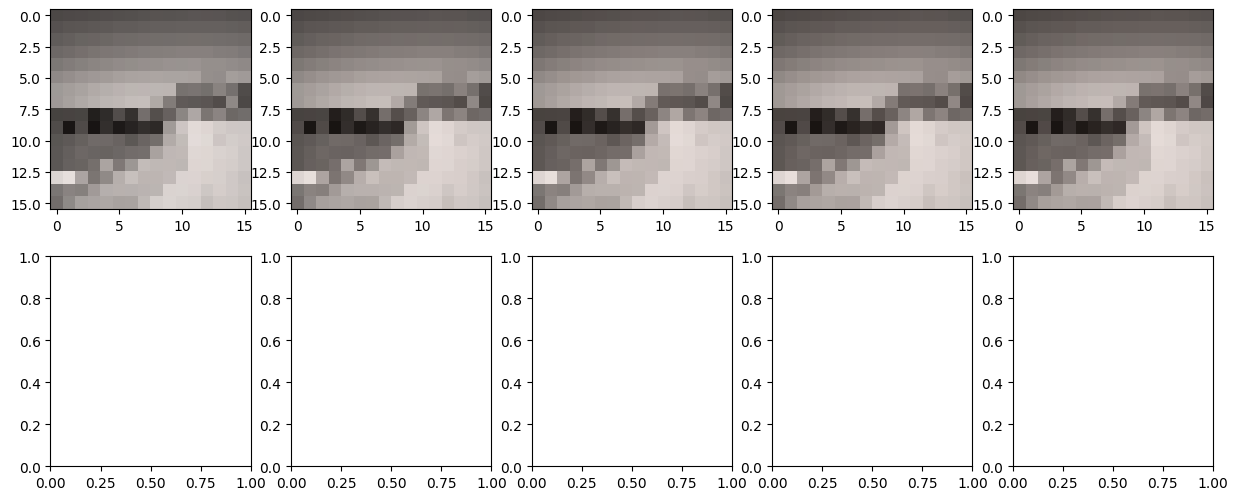

In [8]:
t, ax = plt.subplots(2,5,figsize=(15,6))
for i, axis in enumerate(ax[0]):
    axis.imshow(saved_epochs[i])
#for j, axis in enumerate(ax[1]):
#    axis.imshow(saved_epochs[5+i])

In [9]:
losses = [x.to('cpu').detach().numpy() for x in losses]

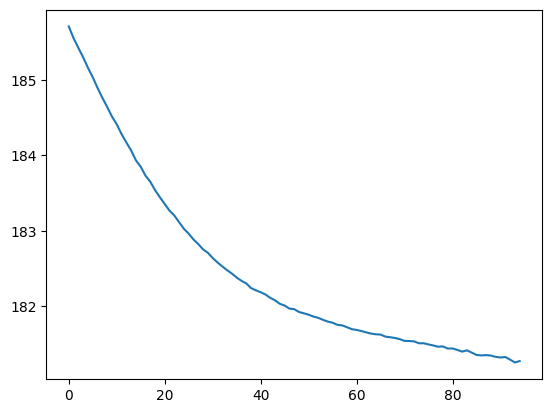

In [10]:
plt.plot(range(len(losses)),losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


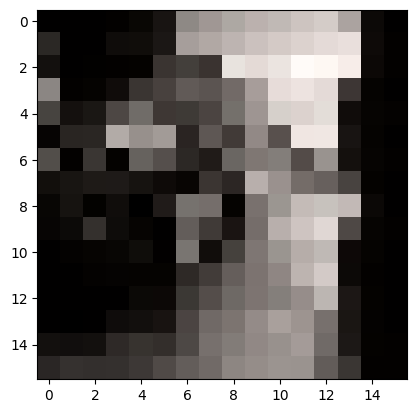

In [11]:
x, y = train_dataset.load_image_number(12)
x, y = x.to('cuda'), y.to('cuda')
predictions = gen.colorize(x)
plt.imshow(predictions.to('cpu').detach().numpy())

In [12]:
from torchview import draw_graph

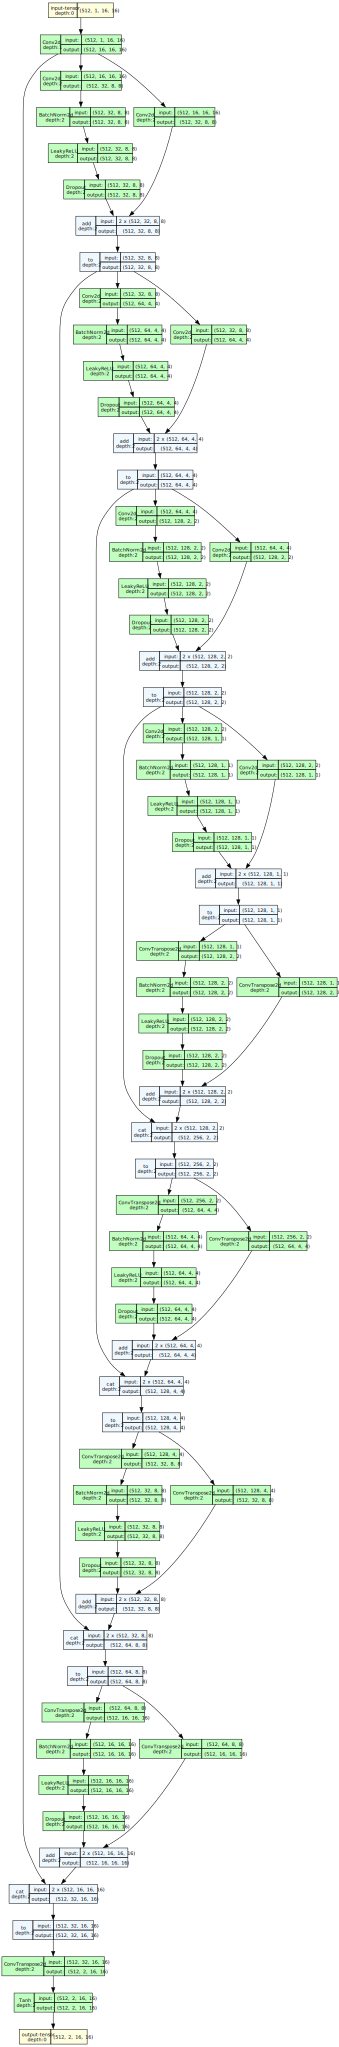

In [13]:
model_graph = draw_graph(gen, input_size=(h_batch_size, 1,h_image_size, h_image_size), device='cuda')
model_graph.visual_graph